# Shelter Animal Outcomes

Using features like breed, color, sex, and age, let's create models for predicting the adoption outcome for each animal to understand trends. (Source: https://www.kaggle.com/c/shelter-animal-outcomes)

### Load, Examine and Cleanup Data

* Convert outcome/target to 1 = Adoption, 0 = everything else
 *  This column has four values: euthanized, transfered, returned to ownder, adopted
 *  Goal is to predict whether the pet will (remain) adopted or not
* Drop columns not needed for modeling
* Inspect columns with missing values
 *  Remove small fraction of samples with missing values
* Remove 22 rows with "0 years" as age
 *  Convert age from string to # of days
 *  The values are like so "1 month", "2 years", "4 days", "3 weeks" etc.
* Scale age
* One-hot code categorical features -- basically ALL the features except Age

### Visualize Data

### Modeling -- all features

##### Logistic Regression
* Accuracy and coefficients with splitting data 70/30, 80/20, 90/10

##### Decision Tree
* Find accuracy score based on train_test_split 70/30
* Create DecisionTreeClassifier based on the best max_depth observed 
* Plot decision tree
* Compute the feature importances

##### Random Forest with Cross-validation
* Compute cross-validation accuracy across 10 folds along with RandomForestClassifier
* Use GridSearchCV to automate the search for best *max_depth* per-tree
* Plot the results
* Examine the best model
* Use GridSearchCV to automate the search for *max_depth* and *min_samples_leaf*

### Modeling -- with select features
##### Logistic Regression
##### Decision Tree
##### Random Forest with Cross-validation

In [75]:
#data handling/prediction
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.externals.six import StringIO
from sklearn import metrics
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler

#visualization
%matplotlib inline
import seaborn as sns
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz

### Load, Examine and Cleanup Data

In [76]:
# read data into a DataFrame
data = pd.read_csv("../data/data.csv")
print(data.dtypes)
print(data.head())
print(data.shape)

AnimalID          object
Name              object
DateTime          object
OutcomeType       object
OutcomeSubtype    object
AnimalType        object
SexuponOutcome    object
AgeuponOutcome    object
Breed             object
Color             object
dtype: object
  AnimalID     Name             DateTime      OutcomeType OutcomeSubtype  \
0  A671945  Hambone  2014-02-12 18:22:00  Return_to_owner            NaN   
1  A656520    Emily  2013-10-13 12:44:00       Euthanasia      Suffering   
2  A686464   Pearce  2015-01-31 12:28:00         Adoption         Foster   
3  A683430      NaN  2014-07-11 19:09:00         Transfer        Partner   
4  A667013      NaN  2013-11-15 12:52:00         Transfer        Partner   

  AnimalType SexuponOutcome AgeuponOutcome                        Breed  \
0        Dog  Neutered Male         1 year        Shetland Sheepdog Mix   
1        Cat  Spayed Female         1 year       Domestic Shorthair Mix   
2        Dog  Neutered Male        2 years            

In [77]:
data = pd.read_csv("../data/data.csv")
clean_data = data
print("clean_data rows/cols before cleanup: ",clean_data.shape)

# Drop columns we don't need for modeling
del clean_data["Name"]
del clean_data["AnimalID"]
del clean_data["DateTime"]
del clean_data["OutcomeSubtype"]

('clean_data rows/cols before cleanup: ', (26729, 10))


In [78]:
# Convert outcome to 1 = Adoption, 0 = everything else
print(clean_data.OutcomeType.value_counts())
# clean_data.loc[:,('OutcomeType')] = (clean_data.OutcomeType=='Adoption').astype(int)
clean_data['OutcomeType'] = (clean_data.OutcomeType=='Adoption').astype(int)
print(clean_data.OutcomeType.value_counts())

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64
0    15960
1    10769
Name: OutcomeType, dtype: int64


In [79]:
# Inspect columns with missing values
print("Columns with missing values:")
print(clean_data.isnull().any())
# Check for # of missing values per column
print(clean_data.isnull().sum())

# Delete samples with missing values
clean_data_nonnull = clean_data.dropna()
print("Fraction of data kept:\n",float(clean_data_nonnull.shape[0])/clean_data.shape[0])
clean_data = clean_data_nonnull

Columns with missing values:
OutcomeType       False
AnimalType        False
SexuponOutcome     True
AgeuponOutcome     True
Breed             False
Color             False
dtype: bool
OutcomeType        0
AnimalType         0
SexuponOutcome     1
AgeuponOutcome    18
Breed              0
Color              0
dtype: int64
('Fraction of data kept:\n', 0.9992891615847955)


In [80]:
clean_data.AgeuponOutcome.value_counts()

1 year       3969
2 years      3742
2 months     3397
3 years      1823
1 month      1281
3 months     1277
4 years      1071
5 years       992
4 months      888
6 years       670
3 weeks       659
5 months      652
6 months      588
8 years       536
7 years       530
2 weeks       529
10 months     457
10 years      446
8 months      402
4 weeks       334
9 years       288
7 months      288
12 years      234
9 months      224
1 weeks       171
11 months     166
1 week        146
13 years      143
11 years      126
3 days        109
2 days         99
14 years       97
15 years       85
1 day          66
6 days         50
4 days         50
16 years       36
5 days         24
0 years        22
17 years       17
5 weeks        11
18 years       10
19 years        3
20 years        2
Name: AgeuponOutcome, dtype: int64

In [81]:
def convert_age_to_days(age):
    a,unit = age.split(" ")
    a = int(a)
    num_of_days = 0
    mult = 1
    if unit == "years" or unit == "year":
        mult = 365
    elif unit == "months" or unit == "month":
        mult = 30
    elif unit == "weeks" or unit == "week":
        mult = 7
        
    num_of_days = a * mult
    return num_of_days

In [82]:
# Remove 22 rows with "0 years" as age
clean_data = clean_data[clean_data.AgeuponOutcome != "0 years"]

# Convert age from string to number of days
# clean_data["AgeuponOutcomeInDays"] = clean_data["AgeuponOutcome"].apply(convert_age_to_days)
clean_data.loc[:,('AgeuponOutcome')] = clean_data["AgeuponOutcome"].apply(convert_age_to_days)
clean_data.AgeuponOutcome.value_counts().sort_values(ascending=False)

365     3969
730     3742
60      3397
1095    1823
30      1281
90      1277
1460    1071
1825     992
120      888
2190     670
21       659
150      652
180      588
2920     536
2555     530
14       529
300      457
3650     446
240      402
28       334
7        317
3285     288
210      288
4380     234
270      224
330      166
4745     143
4015     126
3        109
2         99
5110      97
5475      85
1         66
6         50
4         50
5840      36
5         24
6205      17
35        11
6570      10
6935       3
7300       2
Name: AgeuponOutcome, dtype: int64

In [83]:
clean_age_data = clean_data.AgeuponOutcome.values.reshape(-1, 1)

# Scale clean_data.AgeuponOutcome
scaler = StandardScaler() #create a scaler object
scaler.fit_transform(clean_age_data) #fit the scaler
clean_age_data_scaled = scaler.transform(clean_age_data) #transform the data with it

# compare original to standardized
# print("original values:\n",clean_age_data[:10],"\n")
# print("scaled values:\n",clean_age_data_scaled[:10],"\n")

# figure out how the standardization worked
print("Mean of column:\n",scaler.mean_,"\n")
print("standard deviation of column:\n",scaler.scale_,"\n")
print("Final Means of scaled data:\n",clean_age_data_scaled.mean(axis=0))
print("Final standard deviation of scaled data:\n",clean_age_data_scaled.std(axis=0))

clean_data.loc[:,("AgeuponOutcome")] = clean_age_data_scaled

print("Age min value: ",clean_data.AgeuponOutcome.min())
print("Age min value: ",clean_data.AgeuponOutcome.max())

('Mean of column:\n', array([ 794.71942446]), '\n')
('standard deviation of column:\n', array([ 1082.98267468]), '\n')
('Final Means of scaled data:\n', array([ -1.95686792e-17]))
('Final standard deviation of scaled data:\n', array([ 1.]))
('Age min value: ', -0.73290131321242524)
('Age min value: ', 6.0068186939853723)


In [84]:
# One-hot code AnimalType - Dog or Cat
animal_type_one_coded = clean_data.AnimalType.str.get_dummies()

In [85]:
# One-hot code SexuponOutcome
sex_upon_outcome_one_coded = clean_data.SexuponOutcome.str.get_dummies()

In [86]:
# One-hot code Color
# print(clean_data.Color.value_counts())
popular_colors = clean_data.Color.value_counts(ascending=False).head(5)
print("Top 5 colors: ",popular_colors)

def color_bucket(color):
    if color in popular_colors:
        return color
    
    return "OtherColor"

clean_data.loc[:,("Color")] = clean_data["Color"].apply(color_bucket)
color_one_coded = clean_data.Color.str.get_dummies()

('Top 5 colors: ', Black/White          2824
Black                2286
Brown Tabby          1628
Brown Tabby/White     939
White                 924
Name: Color, dtype: int64)


In [87]:
# One-hot code Breed
popular_breeds = clean_data.Breed.value_counts(ascending=False).head(5)
print("Top 5 breeds: ",popular_breeds)

def breed_bucket(breed):
    if breed in popular_breeds:
        return breed
    
    return "OtherBreed"

clean_data.loc[:,("Breed")] = clean_data["Breed"].apply(breed_bucket)
breed_one_coded = clean_data.Breed.str.get_dummies()

('Top 5 breeds: ', Domestic Shorthair Mix      8780
Pit Bull Mix                1906
Chihuahua Shorthair Mix     1766
Labrador Retriever Mix      1363
Domestic Medium Hair Mix     839
Name: Breed, dtype: int64)


In [88]:
# Merge one-hot coded dataframes with the original df
clean_data = clean_data.merge(animal_type_one_coded,left_index=True,right_index=True).merge(sex_upon_outcome_one_coded,left_index=True,right_index=True).merge(breed_one_coded,left_index=True,right_index=True).merge(color_one_coded,left_index=True,right_index=True)
print(clean_data.head())

# Drop original columns that aren't needed anymore
del clean_data["Breed"]
del clean_data["AnimalType"]
del clean_data["SexuponOutcome"]
del clean_data["Color"]

   OutcomeType AnimalType SexuponOutcome  AgeuponOutcome  \
0            0        Dog  Neutered Male       -0.396793   
1            0        Cat  Spayed Female       -0.396793   
2            1        Dog  Neutered Male       -0.059760   
3            0        Cat    Intact Male       -0.714434   
4            0        Dog  Neutered Male       -0.059760   

                    Breed       Color  Cat  Dog  Intact Female  Intact Male  \
0              OtherBreed  OtherColor    0    1              0            0   
1  Domestic Shorthair Mix  OtherColor    1    0              0            0   
2            Pit Bull Mix  OtherColor    0    1              0            0   
3  Domestic Shorthair Mix  OtherColor    1    0              0            1   
4              OtherBreed  OtherColor    0    1              0            0   

   ...    Domestic Shorthair Mix  Labrador Retriever Mix  OtherBreed  \
0  ...                         0                       0           1   
1  ...              

In [89]:
clean_data.columns = clean_data.columns.map(lambda x: x.replace(" ",""))
clean_data.columns = clean_data.columns.map(lambda x: x.replace("/",""))

In [90]:
# Examine split of adopted vs not
print(clean_data.OutcomeType.value_counts())
print(clean_data.OutcomeType.value_counts()/clean_data.OutcomeType.value_counts().sum())

0    15919
1    10769
Name: OutcomeType, dtype: int64
0    0.596485
1    0.403515
Name: OutcomeType, dtype: float64


In [91]:
clean_data.head()

OutcomeType  AgeuponOutcome  Cat  Dog  IntactFemale  IntactMale  \
0            0       -0.396793    0    1             0           0   
1            0       -0.396793    1    0             0           0   
2            1       -0.059760    0    1             0           0   
3            0       -0.714434    1    0             0           1   
4            0       -0.059760    0    1             0           0   

   NeuteredMale  SpayedFemale  Unknown  ChihuahuaShorthairMix  ...    \
0             1             0        0                      0  ...     
1             0             1        0                      0  ...     
2             1             0        0                      0  ...     
3             0             0        0                      0  ...     
4             1             0        0                      0  ...     

   DomesticShorthairMix  LabradorRetrieverMix  OtherBreed  PitBullMix  Black  \
0                     0                     0           1           0      0   
1                     1                     0           0           0      0   
2                     0                     0           0           1      0   
3                     1                     0           0           0      0   
4                     0                     0           1           0      0   

   BlackWhite  BrownTabby  BrownTabbyWhite  OtherColor  White  
0           0           0                0           1      0  
1           0           0                0           1      0  
2           0           0                0           1      0  
3           0           0                0           1      0  
4           0           0                0           1      0  

[5 rows x 21 columns]

### Visualize Data

Split data into (adopted vs not) and plot correlation matrix heatmaps 

In [92]:
adopted_data = pd.DataFrame(clean_data[clean_data.OutcomeType == 1])
not_adopted_data = pd.DataFrame(clean_data[clean_data.OutcomeType == 0])

adopted_data.drop(['OutcomeType'],inplace=True, axis=1)
not_adopted_data.drop(['OutcomeType'],inplace=True, axis=1)

Adoped pets

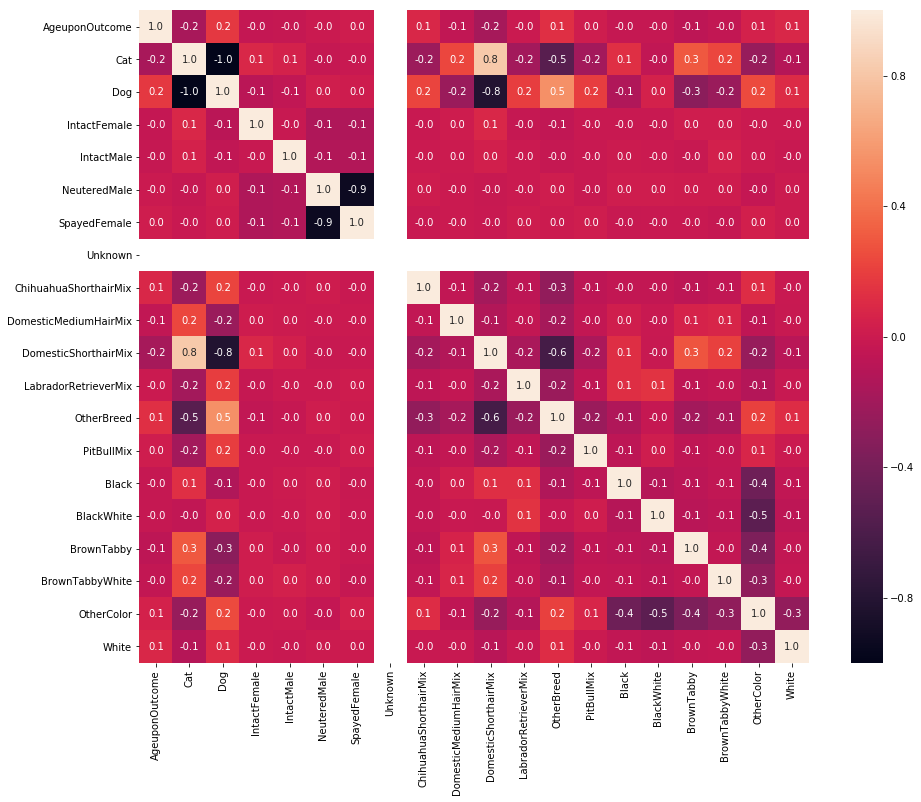

In [93]:
sns.mpl.pyplot.figure(figsize=(15, 12))
sns.heatmap(adopted_data.corr(),annot=True, fmt=".1f");

Not adopted pets

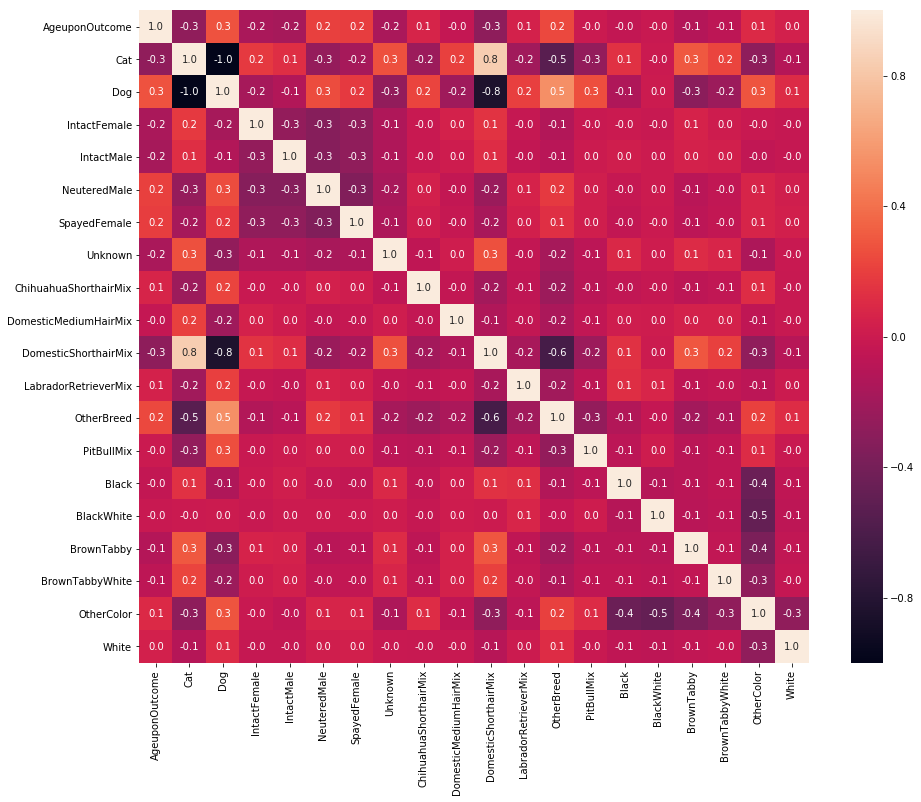

In [94]:
sns.mpl.pyplot.figure(figsize=(15, 12))
sns.heatmap(not_adopted_data.corr(),annot=True, fmt=".1f");

## Modeling -- All Features

### Logistic Regression

Accuracy and coefficients with splitting data 70/30, 80/20, 90/10

In [95]:
selected_features = clean_data.columns.tolist()[1:]
all_features_X = clean_data[selected_features]
all_y = clean_data.OutcomeType

for n in [0.3,0.2,0.1]:
    all_X_train,all_X_test,all_y_train,all_y_test = train_test_split(all_features_X,all_y,test_size=n,random_state=1)
    
    logreg_all = LogisticRegression(C=1e9)
    logreg_all.fit(all_X_train,all_y_train)
    
    print("### Data split {0}/{1} with all features ###".format(int((1-n) * 100),int(n * 100)))
    print("Bias coefficient (intercept): {0}".format(logreg_all.intercept_[0]))
    print("Model accuracy on {0}% training data: {1}".format(int((1-n) * 100),metrics.accuracy_score(all_y_train,logreg_all.predict(all_X_train))))
    print("Model accuracy on {0}% test data: {1}".format(int(n * 100),metrics.accuracy_score(all_y_test,logreg_all.predict(all_X_test))))
    print("\r") 
    print("Features in order of their absolute coefficient values--indicating their importance")
    feature_coeff_df = pd.DataFrame(list(zip(clean_data.columns.tolist()[1:],logreg_all.coef_[0],abs(logreg_all.coef_[0]))),columns=["feature","coefficient","abs_coefficient"])
    print(feature_coeff_df.sort_values(['abs_coefficient'],ascending=False))
    print("\n")

### Data split 70/30 with all features ###
Bias coefficient (intercept): -1.6295152777
Model accuracy on 70% training data: 0.746266259836
Model accuracy on 30% test data: 0.739477956788

Features in order of their absolute coefficient values--indicating their importance
                  feature  coefficient  abs_coefficient
7                 Unknown    -7.736521         7.736521
6            SpayedFemale     3.460296         3.460296
5            NeuteredMale     3.225895         3.225895
2                     Dog    -1.104703         1.104703
13             PitBullMix    -0.715058         0.715058
0          AgeuponOutcome    -0.696520         0.696520
1                     Cat    -0.524812         0.524812
4              IntactMale    -0.412378         0.412378
14                  Black    -0.368917         0.368917
10   DomesticShorthairMix    -0.346916         0.346916
19                  White    -0.299667         0.299667
9   DomesticMediumHairMix    -0.297401         0.297401


#### Notes: 
* Logistics Regression model accuracy: ~74%
* If bias coefficient (intercept) is positive, knowing nothing else means assume class 1. If negative, assume class 0. Since in this case it's negative, by default the animals are not getting adopted--which makes sense given the outcome (other vs adopted) split of 60/40. 
* Positive feature coefficients increase the log-odds of the response being 1 (and thus increase the probability), and negative feature coefficients decrease the log-odds of the response being 1 (and thus decrease the probability).
* In other words, negative feature coefficients forces outcome closer to 0; Positive feature coefficients forces outcome closer to 1.

### Decision Tree

Find accuracy score based on train_test_split 70/30

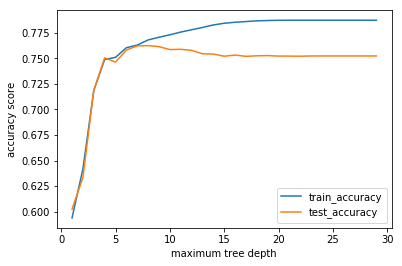

In [96]:
X_train,X_test,y_train,y_test = train_test_split(all_features_X,all_y,test_size=.3,random_state=1)

depths = range(1,30)
train_accuracy, test_accuracy = [],[]
for depth in depths:
    decision_tree = DecisionTreeClassifier(max_depth=depth,random_state=10)
    decision_tree.fit(X_train,y_train)
    curr_train_accuracy = metrics.accuracy_score(y_train,decision_tree.predict(X_train))
    curr_test_accuracy = metrics.accuracy_score(y_test,decision_tree.predict(X_test))
#     print("Decision Tree Train/Test accuracy for depth "+str(depth),curr_train_accuracy," ",curr_test_accuracy)
    train_accuracy.append(curr_train_accuracy)
    test_accuracy.append(curr_test_accuracy)
sns.mpl.pyplot.plot(depths,train_accuracy,label='train_accuracy')
sns.mpl.pyplot.plot(depths,test_accuracy,label='test_accuracy')
sns.mpl.pyplot.xlabel("maximum tree depth")
sns.mpl.pyplot.ylabel("accuracy score")
sns.mpl.pyplot.legend()

In [97]:
#DecisionTreeClassifier based on the best max_depth = 8 observed above
best_single_tree = DecisionTreeClassifier(max_depth=8, random_state=1)
best_single_tree.fit(X_train,y_train)
print("Best Decision Tree Accuracy Score:",metrics.accuracy_score(y_test,best_single_tree.predict(X_test)))

('Best Decision Tree Accuracy Score:', 0.76245784938179095)


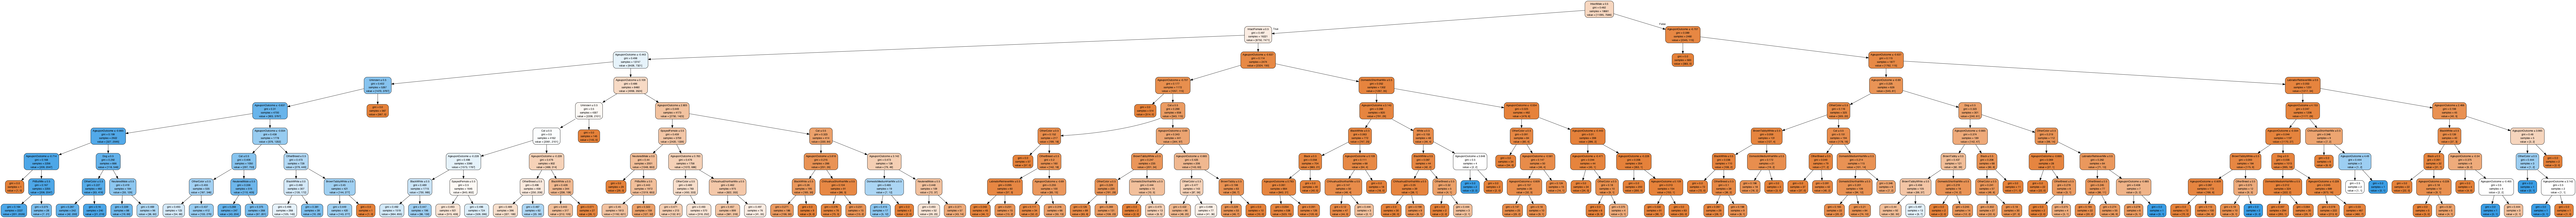

In [98]:
#Plot decision tree
dot_data = StringIO()  
export_graphviz(best_single_tree, out_file=dot_data,  
                    feature_names=X_train.columns.tolist(),  
                    filled=True, rounded=True,  
                    special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

In [99]:
#Compute the feature importances
feature_imp = pd.DataFrame({'feature':X_train.columns.tolist(), 'importance':best_single_tree.feature_importances_})
print(feature_imp.sort_values("importance",ascending=False))

                  feature  importance
3            IntactFemale    0.268340
0          AgeuponOutcome    0.267403
7                 Unknown    0.210285
4              IntactMale    0.210217
1                     Cat    0.015379
6            SpayedFemale    0.004819
15             BlackWhite    0.003557
5            NeuteredMale    0.003499
12             OtherBreed    0.003446
18             OtherColor    0.003411
2                     Dog    0.002820
13             PitBullMix    0.002082
17        BrownTabbyWhite    0.001231
8   ChihuahuaShorthairMix    0.001200
9   DomesticMediumHairMix    0.000601
16             BrownTabby    0.000497
19                  White    0.000435
11   LabradorRetrieverMix    0.000344
10   DomesticShorthairMix    0.000267
14                  Black    0.000166


### Random Forest with Cross-validation

Compute cross-validation accuracy across 10 folds

In [64]:
rf = RandomForestClassifier(n_estimators=50) #random forest with 50 trees

# Compute cross-validation score accuracy across 10 folds
cross_val_scores = cross_val_score(rf,all_features_X,all_y,cv=10)
print("10-fold accuracies:\n",cross_val_scores)
print("Mean cv-accuracy:",np.mean(cross_val_scores))
print("Std of cv-accuracy:",np.std(cross_val_scores))

('10-fold accuracies:\n', array([ 0.74522293,  0.76170851,  0.75946047,  0.75983514,  0.74747096,
        0.75046834,  0.74784564,  0.76620457,  0.7523417 ,  0.76377953]))
('Mean cv-accuracy:', 0.75543377890802232)
('Std of cv-accuracy:', 0.0072116868725521392)


Use GridSearchCV to automate the search for best *max_depth* per-tree across 50 tress

('Best score:', 0.7642386091127098)
('Best params:', {'max_depth': 8})
('Best estimator:', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False))


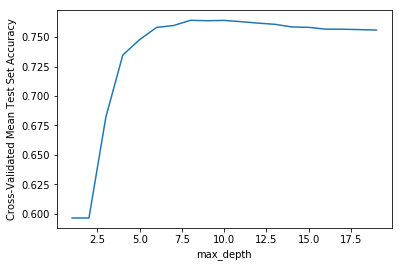

In [90]:
# Use GridSearchCV to automate the search to find best max_depth per-tree across depths 1-10
rf_grid = RandomForestClassifier(n_estimators=50,random_state=1,n_jobs=-1) #50 trees
max_depth_range = range(1, 20)
param_grid = dict(max_depth=max_depth_range)
grid = GridSearchCV(rf_grid, param_grid, cv=10, scoring='accuracy')
grid.fit(all_features_X, all_y)

# Examine the results of the grid search
# grid.cv_results_

grid_mean_scores = grid.cv_results_["mean_test_score"]

# Plot the results
sns.mpl.pyplot.plot(max_depth_range, grid_mean_scores)
sns.mpl.pyplot.xlabel('max_depth')
sns.mpl.pyplot.ylabel('Cross-Validated Mean Test Set Accuracy')

# Examine the best model
print("Best score:",grid.best_score_)
print("Best params:",grid.best_params_)
print("Best estimator:",grid.best_estimator_)

Use GridSearchCV to automate the search for multiple parameters (*max_depth* and *min_samples_leaf*) across 50 trees

In [67]:
# Use GridSearchCV to automate the search for multiple parameters 
# (max_depth and min_samples_leaf) across 50 trees with depths range 1-10 and leaf samples range 1-8
rf_grid = RandomForestClassifier(n_estimators=50,random_state=1,n_jobs=-1) 
max_depth_range = range(1, 20)
leaf_range = range(1, 10)
param_grid2 = dict(max_depth=max_depth_range, min_samples_leaf=leaf_range)
grid2 = GridSearchCV(rf_grid, param_grid2, cv=10, scoring='accuracy')
grid2.fit(all_features_X, all_y)

print("Best GridSearchCV score:",grid2.best_score_)
print("Best GridSearchCV params:",grid2.best_params_)

('Best GridSearchCV score:', 0.76498800959232616)
('Best GridSearchCV params:', {'max_depth': 10, 'min_samples_leaf': 3})


## Modeling -- Select Features

Top 5 features selected based on importance generated by DecisionTreeClassifier

In [100]:
print("Top 5 features based on importance generated by DecisionTreeClassifier:",
      feature_imp.sort_values("importance",ascending=False).head(5))

selected_features = feature_imp.sort_values("importance",ascending=False).head(5).loc[:,'feature'].tolist()
select_features_X = clean_data[selected_features]
all_y = clean_data.OutcomeType

('Top 5 features based on importance generated by DecisionTreeClassifier:',           feature  importance
3    IntactFemale    0.268340
0  AgeuponOutcome    0.267403
7         Unknown    0.210285
4      IntactMale    0.210217
1             Cat    0.015379)


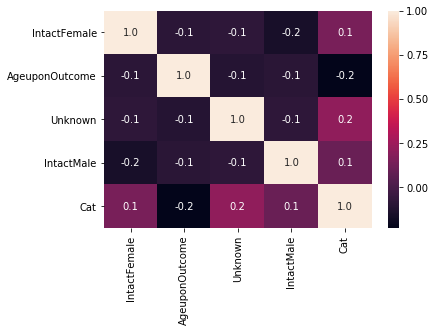

In [104]:
sns.mpl.pyplot.figure()
sns.heatmap(select_features_X.corr(),annot=True, fmt=".1f");

### Logistic Regression

In [103]:
print("Selected Features:",selected_features)

for n in [0.3,0.2,0.1]:
    all_X_train,all_X_test,all_y_train,all_y_test = train_test_split(select_features_X,all_y,test_size=n,random_state=1)
    
    logreg_all = LogisticRegression(C=1e9)
    logreg_all.fit(all_X_train,all_y_train)
    
    print("### Data split {0}/{1} with all features ###".format(int((1-n) * 100),int(n * 100)))
    print("Bias coefficient (intercept): {0}".format(logreg_all.intercept_[0]))
    print("Model accuracy on {0}% training data: {1}".format(int((1-n) * 100),metrics.accuracy_score(all_y_train,logreg_all.predict(all_X_train))))
    print("Model accuracy on {0}% test data: {1}".format(int(n * 100),metrics.accuracy_score(all_y_test,logreg_all.predict(all_X_test))))
    print("\r") 
    print("Features in order of their absolute coefficient values--indicating their importance")
    feature_coeff_df = pd.DataFrame(list(zip(selected_features,logreg_all.coef_[0],abs(logreg_all.coef_[0]))),columns=["feature","coefficient","abs_coefficient"])
    print(feature_coeff_df.sort_values(['abs_coefficient'],ascending=False))
    print("\n")

('Selected Features:', ['IntactFemale', 'AgeuponOutcome', 'Unknown', 'IntactMale', 'Cat'])
### Data split 70/30 with all features ###
Bias coefficient (intercept): 0.178293814553
Model accuracy on 70% training data: 0.746105668861
Model accuracy on 30% test data: 0.743224678406

Features in order of their absolute coefficient values--indicating their importance
          feature  coefficient  abs_coefficient
2         Unknown   -11.152873        11.152873
3      IntactMale    -3.758031         3.758031
0    IntactFemale    -3.505345         3.505345
1  AgeuponOutcome    -0.682743         0.682743
4             Cat     0.448691         0.448691


### Data split 80/20 with all features ###
Bias coefficient (intercept): 0.17027156578
Model accuracy on 80% training data: 0.745480093677
Model accuracy on 20% test data: 0.744286249532

Features in order of their absolute coefficient values--indicating their importance
          feature  coefficient  abs_coefficient
2         Unknown   -11.16

#### Notes:
* Logistics Regression model accuracy: ~74%
* If bias coefficient (intercept) is positive, knowing nothing else means assume class 1. If negative, assume class 0. Since in this case it's **positive**, by default the animals are getting adopted.
* Positive feature coefficients increase the log-odds of the response being 1 (and thus increase the probability), and negative feature coefficients decrease the log-odds of the response being 1 (and thus decrease the probability).
* In other words, negative feature coefficients forces outcome closer to 0; Positive feature coefficients forces outcome closer to 1.

### Decision Tree

('Selected Features:', ['IntactFemale', 'AgeuponOutcome', 'Unknown', 'IntactMale', 'Cat'])


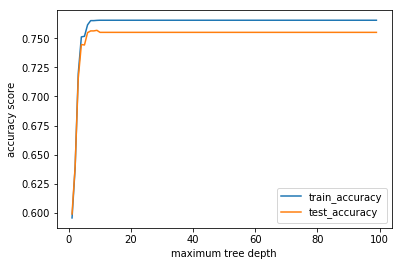

In [84]:
print("Selected Features:",selected_features)

X_train,X_test,y_train,y_test = train_test_split(select_features_X,all_y,test_size=.3,random_state=123)

depths = range(1,100)
train_accuracy, test_accuracy = [],[]
for depth in depths:
    decision_tree = DecisionTreeClassifier(max_depth=depth,random_state=10)
    decision_tree.fit(X_train,y_train)
    curr_train_accuracy = metrics.accuracy_score(y_train,decision_tree.predict(X_train))
    curr_test_accuracy = metrics.accuracy_score(y_test,decision_tree.predict(X_test))
#     print("Decision Tree Train/Test accuracy for depth "+str(depth),curr_train_accuracy," ",curr_test_accuracy)
    train_accuracy.append(curr_train_accuracy)
    test_accuracy.append(curr_test_accuracy)
sns.mpl.pyplot.plot(depths,train_accuracy,label='train_accuracy')
sns.mpl.pyplot.plot(depths,test_accuracy,label='test_accuracy')
sns.mpl.pyplot.xlabel("maximum tree depth")
sns.mpl.pyplot.ylabel("accuracy score")
sns.mpl.pyplot.legend()

In [100]:
#DecisionTreeClassifier based on the best max_depth = 6 observed from 10 trials
best_single_tree = DecisionTreeClassifier(max_depth=8, random_state=1)
best_single_tree.fit(X_train,y_train)
print("Best Decision Tree Accuracy Score:",metrics.accuracy_score(y_test,best_single_tree.predict(X_test)))

('Best Decision Tree Accuracy Score:', 0.75646309479205698)


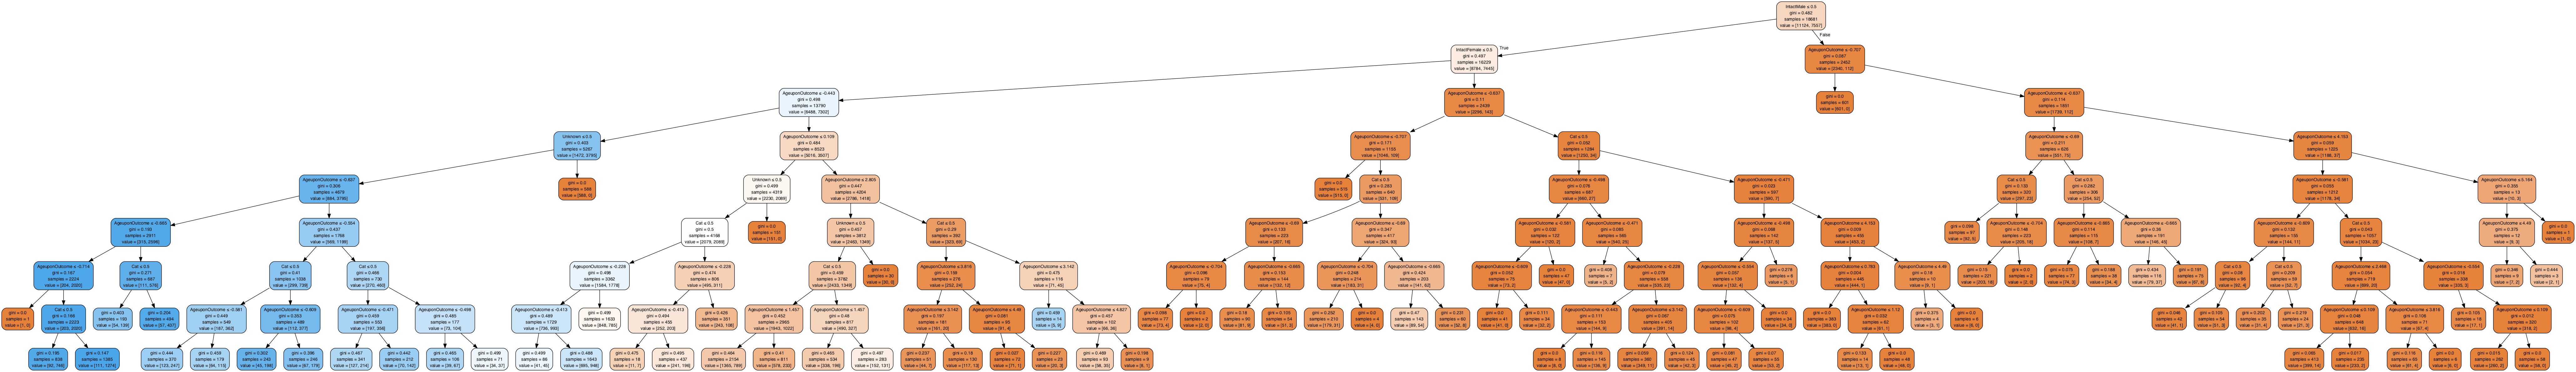

In [92]:
#Plot decision tree
dot_data = StringIO()  
export_graphviz(best_single_tree, out_file=dot_data,  
                    feature_names=X_train.columns.tolist(),  
                    filled=True, rounded=True,  
                    special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

#### Notes:
* Best Decision Tree Accuracy Score: ~76%

### Random Forest with Cross-validation

In [93]:
print("Selected Features:",selected_features)

rf = RandomForestClassifier(n_estimators=50) #random forest with 50 trees

# Compute cross-validation score accuracy across 10 folds
cross_val_scores = cross_val_score(rf,select_features_X,all_y,cv=10)
print("10-fold accuracies:\n",cross_val_scores)
print("Mean cv-accuracy:",np.mean(cross_val_scores))
print("Std of cv-accuracy:",np.std(cross_val_scores))

('Selected Features:', ['IntactFemale', 'AgeuponOutcome', 'Unknown', 'IntactMale', 'Cat'])
('10-fold accuracies:\n', array([ 0.749719  ,  0.76920195,  0.76732859,  0.75946047,  0.75496441,
        0.75721244,  0.7590858 ,  0.77219933,  0.76133383,  0.76715411]))
('Mean cv-accuracy:', 0.76176599131552913)
('Std of cv-accuracy:', 0.0067002557913376807)


('Selected Features:', ['IntactFemale', 'AgeuponOutcome', 'Unknown', 'IntactMale', 'Cat'])
('Best score:', 0.76266486810551559)
('Best params:', {'max_depth': 10})
('Best estimator:', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False))


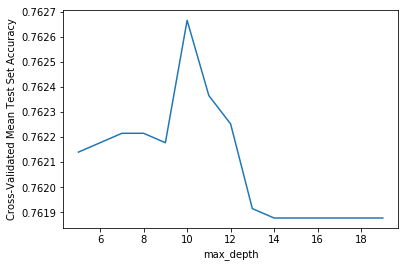

In [94]:
print("Selected Features:",selected_features)

# Use GridSearchCV to automate the search to find best max_depth per-tree across depths 1-10
rf_grid = RandomForestClassifier(n_estimators=50,random_state=1,n_jobs=-1) #50 trees
max_depth_range = range(5, 20)
param_grid = dict(max_depth=max_depth_range)
grid = GridSearchCV(rf_grid, param_grid, cv=10, scoring='accuracy')
grid.fit(select_features_X, all_y)

# Examine the results of the grid search
# grid.cv_results_

grid_mean_scores = grid.cv_results_["mean_test_score"]

# Plot the results
sns.mpl.pyplot.plot(max_depth_range, grid_mean_scores)
sns.mpl.pyplot.xlabel('max_depth')
sns.mpl.pyplot.ylabel('Cross-Validated Mean Test Set Accuracy')

# Examine the best model
print("Best score:",grid.best_score_)
print("Best params:",grid.best_params_)
print("Best estimator:",grid.best_estimator_)

In [95]:
# Use GridSearchCV to automate the search for multiple parameters 
# (max_depth and min_samples_leaf) across 50 trees with depths range 1-10 and leaf samples range 1-8
rf_grid = RandomForestClassifier(n_estimators=50,random_state=1,n_jobs=-1) 
max_depth_range = range(5, 20)
leaf_range = range(1, 8)
param_grid2 = dict(max_depth=max_depth_range, min_samples_leaf=leaf_range)
grid2 = GridSearchCV(rf_grid, param_grid2, cv=10, scoring='accuracy')
grid2.fit(select_features_X, all_y)

print("Best GridSearchCV score:",grid2.best_score_)
print("Best GridSearchCV params:",grid2.best_params_)

('Best GridSearchCV score:', 0.76266486810551559)
('Best GridSearchCV params:', {'max_depth': 10, 'min_samples_leaf': 1})
